In [1]:
from typing import Any, Optional
from uuid import UUID

from dotenv import load_dotenv

from langchain.callbacks.base import BaseCallbackHandler

from genai import Client, Credentials
from genai.extensions.langchain import LangChainInterface
from genai.text.generation import (
    DecodingMethod,
    ModerationHAP,
    ModerationParameters,
    TextGenerationParameters,
)

import warnings
warnings.filterwarnings("ignore")

# make sure you have a .env file under genai root with
# GENAI_KEY=<your-genai-key>
# GENAI_API=<genai-api-endpoint> (optional) DEFAULT_API = "https://bam-api.res.ibm.com"
load_dotenv()


def heading(text: str) -> str:
    """Helper function for centering text."""
    return "\n" + f" {text} ".center(80, "=") + "\n"


print(heading("Generate text with langchain"))


class Callback(BaseCallbackHandler):
    def on_llm_new_token(
        self,
        token: str,
        *,
        run_id: UUID,
        parent_run_id: Optional[UUID] = None,
        **kwargs: Any,
    ) -> Any:
        print(f"Token received: {token}")


def bam_model(model_id='mistralai/mistral-7b-instruct-v0-2', decoding_method='greedy', max_new_tokens=200, 
              min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):

    if decoding_method == 'greedy':
        decoding_method = DecodingMethod.GREEDY
    else:
        decoding_method = DecodingMethod.SAMPLE

    llm = LangChainInterface(
        # model_id="ibm/granite-13b-chat-v2",
        model_id=model_id,
        client=Client(credentials=Credentials.from_env()),
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        ),
        moderations=ModerationParameters(
            # Threshold is set to very low level to flag everything (testing purposes)
            # or set to True to enable HAP with default settings
            hap=ModerationHAP(input=True, output=True, threshold=0.01)
        ),
    )

    return llm


prompt = "Tell me about IBM."
print(f"Prompt: {prompt}")

llm = bam_model()

result = llm.generate(prompts=[prompt], callbacks=[Callback()])

print(f"Answer: {result.generations[0][0].text}")
print(result.llm_output)
print(result.generations[0][0].generation_info)

/var/folders/kq/tztc1qnx6lld7r6kmwfmpgw40000gn/T/ipykernel_39916/4098516416.py:10: DeprecationWarning: Deprecated import of DecodingMethod from module genai.text.generation. Please use `from genai.schema import DecodingMethod`.
  from genai.text.generation import (
/var/folders/kq/tztc1qnx6lld7r6kmwfmpgw40000gn/T/ipykernel_39916/4098516416.py:10: DeprecationWarning: Deprecated import of ModerationHAP from module genai.text.generation. Please use `from genai.schema import ModerationHAP`.
  from genai.text.generation import (
/var/folders/kq/tztc1qnx6lld7r6kmwfmpgw40000gn/T/ipykernel_39916/4098516416.py:10: DeprecationWarning: Deprecated import of ModerationParameters from module genai.text.generation. Please use `from genai.schema import ModerationParameters`.
  from genai.text.generation import (
/var/folders/kq/tztc1qnx6lld7r6kmwfmpgw40000gn/T/ipykernel_39916/4098516416.py:10: DeprecationWarning: Deprecated import of TextGenerationParameters from module genai.text.generation. Please u


========================= Generate text with langchain =========================

Prompt: Tell me about IBM.
Answer: 

IBM, or International Business Machines Corporation, is an American multinational technology company headquartered in Armonk, New York. It was founded in 1911 and is one of the oldest information technology companies in the world. IBM is known for its hardware, software, and consulting services. It is a major supplier of computer servers, storage systems, and IT infrastructure software. IBM also offers a range of consulting services, including business strategy, technology, and operations consulting. The company has a significant presence in research and development, and it holds numerous patents in various technologies. IBM is a Fortune 500 company and is listed on the New York Stock Exchange under the ticker symbol IBM.

What are some of IBM's notable products and services?

IBM offers a wide range of products and services, but some of its most notable offerings inc

In [2]:
import os
import time
from tqdm import tqdm
tqdm.pandas()

import pandas as pd
# from langchain.llms import WatsonxLLM
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
import langchain
import ast

from llama_index.prompts import PromptTemplate

In [3]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
import numpy as np

bgel_tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-large')
bgel_model = AutoModelForSequenceClassification.from_pretrained('BAAI/bge-reranker-large')
bgel_model.eval()

# Load the tokenizer and the model
colbert_tokenizer = AutoTokenizer.from_pretrained("colbert-ir/colbertv2.0")
colbert_model = AutoModel.from_pretrained("colbert-ir/colbertv2.0")

from langchain.retrievers import ContextualCompressionRetriever
from langchain.text_splitter import CharacterTextSplitter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.embeddings import HuggingFaceBgeEmbeddings

from llama_index.indices.postprocessor import LongLLMLinguaPostprocessor
from rouge import Rouge

## re-usable functions

def read_data(data_path='data/ms-marco-200-rows.csv'):
    df = pd.read_csv(data_path)

    df["ground_truths"] = [ast.literal_eval(gt) for gt in df["ground_truths"] ]
    df["contexts"] = [ast.literal_eval(ctx) for ctx in df["contexts"]]

    def text_to_chunks(texts: str, chunk_length: int = 200, chunk_overlap: int = 25) -> list:
        words = texts.split(' ')
        n = len(words)
        chunks = []
        chunk_number = 1
        i = 0
        while i < n:
            chunk = words[i: min(i + chunk_length, n)]
            i = i + chunk_length - chunk_overlap
            chunk = ' '.join(chunk).strip()
            chunks.append({"text": chunk})
            chunk_number += 1
        return chunks

    df['chunks'] = df['contexts'].apply(lambda x: [i['text'] for i in text_to_chunks(x[0])])

    data = list()
    for i in range(len(df)):
        for j in df['chunks'][i]:
            doc = Document(
                metadata={
                    "question": df['question'][i],
                    "qid": i
                },
                page_content=j)
            data.append(doc)
    
    return df, data

def colbert_reranker(docs, query):

    # start = time.time()
    scores = []

    # Function to compute MaxSim
    def maxsim(query_embedding, document_embedding):
        # Expand dimensions for broadcasting
        # Query: [batch_size, query_length, embedding_size] -> [batch_size, query_length, 1, embedding_size]
        # Document: [batch_size, doc_length, embedding_size] -> [batch_size, 1, doc_length, embedding_size]
        expanded_query = query_embedding.unsqueeze(2)
        expanded_doc = document_embedding.unsqueeze(1)

        # Compute cosine similarity across the embedding dimension
        sim_matrix = torch.nn.functional.cosine_similarity(expanded_query, expanded_doc, dim=-1)

        # Take the maximum similarity for each query token (across all document tokens)
        # sim_matrix shape: [batch_size, query_length, doc_length]
        max_sim_scores, _ = torch.max(sim_matrix, dim=2)

        # Average these maximum scores across all query tokens
        avg_max_sim = torch.mean(max_sim_scores, dim=1)
        return avg_max_sim

    # Encode the query
    query_encoding = colbert_tokenizer(query, return_tensors='pt')
    query_embedding = colbert_model(**query_encoding).last_hidden_state.mean(dim=1)

    # Get score for each document
    for document in docs:
        document_encoding = colbert_tokenizer(document.page_content, return_tensors='pt', truncation=True, max_length=512)
        document_embedding = colbert_model(**document_encoding).last_hidden_state

        # Calculate MaxSim score
        score = maxsim(query_embedding.unsqueeze(0), document_embedding)
        scores.append({
            "score": score.item(),
            "document": document.page_content,
        })

    # print(f"Took {time.time() - start} seconds to re-rank documents with ColBERT.")

    # Sort the scores by highest to lowest and print
    sorted_data = sorted(scores, key=lambda x: x['score'], reverse=True)

    return sorted_data

def bge_reranker(docs, query):

    pairs = list()
    for document in docs:
        pairs.append([query, document.page_content])

    with torch.no_grad():
        inputs = bgel_tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
        scores = bgel_model(**inputs, return_dict=True).logits.view(-1, ).float()
        # print(scores)

    scrs = list()
    for sc, dc in zip(scores, pairs):
        scrs.append({
                "score": sc,
                "document": dc[1],
            }
        )
    
    # Sort the scores by highest to lowest and print
    sorted_data = sorted(scrs, key=lambda x: x['score'], reverse=True)

    return sorted_data

def prompt_generation(context, query):
    template = (
        "[INST] \n"
        "Context: {context} \n"
        "<<SYS>> \n"
        "- Take the context above and use that to answer questions in a detailed and professional way. \n"
        "- if you dont know the answer just say ” i dont know “. \n"
        "- refrain from using any other knowledge other than the text provided. \n"
        "- don't mention that you are answering from the text, impersonate as if this is coming from your knowledge \n"
        "- For the questions whose answer is not available in the provided context, just say please ask a relevant question or frame the question more clearly. \n"
        "<</SYS>> \n"
        "Question: {query}? \n"
        "[/INST] \n"
    )

    qa_template = PromptTemplate(template)

    return qa_template.format(context=context, query=query)

def compression_retriever(method, retriever=None, embeddings=None, llm=None):
    
    if method == 'LLMChainExtractor':
        
        compressor = LLMChainExtractor.from_llm(llm)
        compression_retriever = ContextualCompressionRetriever(
            base_compressor=compressor, base_retriever=retriever
        )
        return compression_retriever
    
    elif method == 'EmbeddingsFilter':
        embeddings = HuggingFaceBgeEmbeddings()
        embeddings = embeddings
        embeddings_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.76)
        compression_retriever = ContextualCompressionRetriever(
            base_compressor=embeddings_filter, base_retriever=retriever
        )
        return compression_retriever

    elif method == 'DocumentCompressorPipeline':

        embeddings = HuggingFaceBgeEmbeddings() #embeddings #
        splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0, separator=". ")
        redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)
        relevant_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.76)
        pipeline_compressor = DocumentCompressorPipeline(
            transformers=[splitter, redundant_filter, relevant_filter]
        )

        compression_retriever = ContextualCompressionRetriever(
            base_compressor=pipeline_compressor, base_retriever=retriever
        )
        return compression_retriever
    
    else:  #LLMLingua

        node_postprocessor = LongLLMLinguaPostprocessor(
            model_name='NousResearch/Llama-2-7b-hf', #'NousResearch/Nous-Hermes-2-Mixtral-8x7B-SFT',
            device_map='cpu',
            instruction_str="Given the context, please answer the final question",
            target_token=300,
            rank_method="longllmlingua",
            additional_compress_kwargs={
                "condition_compare": True,
                "condition_in_question": "after",
                "context_budget": "+100",
                "reorder_context": "sort",  # enable document reorder,
                "dynamic_context_compression_ratio": 0.3,
            },
        )
        return node_postprocessor

def compression_metric(docs, compressed_docs):
    original_contexts_len = len("\n\n".join([d.page_content for i, d in enumerate(docs)]))
    compressed_contexts_len = len("\n\n".join([d.page_content for i, d in enumerate(compressed_docs)]))

    print("Original context length:", original_contexts_len)
    print("Compressed context length:", compressed_contexts_len)
    print("Compressed Ratio:", f"{original_contexts_len/(compressed_contexts_len + 1e-5):.2f}x")

def score_answers(_answers, _reference, score_type="rouge-l", val="r", use_rouge=True):
    """
    Compute the score of a set of answers, given a set of references, using Rouge score.
    :param answers: Union[List[str], str]
       - the returned answer/answers.
    :param reference:
        - the reference answers, in a list
    :param use_rouge: Boolean
        - if true, then use rouge for scoring, otherwise use substring.
    :return:
       - The maximum rouge-L score of the cartesian product of answers/references
    """
    if isinstance(_answers, str):
        _answers = [_answers]
    _references = _reference
    max_score = -1
    scorer = Rouge()
    closest_ref = ""
    for ref in _references:
        for _answer in _answers:
            if use_rouge:
                scores = scorer.get_scores(_answer.lower(), ref)
                score = scores[0][score_type][val]
            else:
                score = int(ref.find(_answer.lower()) >= 0)
            if score > max_score:
                max_score = score
                closest_ref = ref

    return max_score, closest_ref

def processing(df, retriever, llm, re_ranker, output_path='data/output-baseline-mistral.xlsx'):
    df = df.iloc[:50] # taking only 50 samples
    df.rename({'contexts': 'orig_contexts'}, axis=1, inplace=True)
    try:
        if re_ranker == "colbert":
            df['retrieved_contexts'] = df['question'].apply(lambda x : [i['document'] for i in colbert_reranker(retriever.get_relevant_documents(x)[:3], x)])
        elif re_ranker == "bge":
            df['retrieved_contexts'] = df['question'].apply(lambda x : [i['document'] for i in bge_reranker(retriever.get_relevant_documents(x)[:3], x)])
        else:
            df['retrieved_contexts'] = df['question'].apply(lambda x : [i.page_content for i in retriever.get_relevant_documents(x)[:3]]) # only top 3 in case of compression as well

        answers = list()
        for rc, q in tqdm(zip(df.retrieved_contexts, df.question), total=len(df)):
            prompt = prompt_generation(context="\n".join(rc), query=q)
            ans = llm.generate(prompts=[prompt], callbacks=[Callback()]).generations[0][0].text.strip()
            answers.append(ans)

        df['answer'] = answers
        df.to_excel(output_path, index=False)

        recall, precision = list(), list()
        for grd_truth, ans in tqdm(zip(df.ground_truths, df.answer), total=len(df)):
            r_score, _ = score_answers(ans, grd_truth, val='r')
            recall.append(100*r_score)

            p_score, _ = score_answers(ans, grd_truth, val='p')
            precision.append(100*p_score)

        recall_score = np.mean(recall)
        precision_score = np.mean(precision)

        return df, recall_score, precision_score
    except Exception as e:
        print(e)
        return None, None, None

###############################################################################################################

In [4]:
# Initialise the embedding model
model_name = 'BAAI/bge-large-en' #"intfloat/e5-large-v2" 
model_kwargs = {'device': 'cpu'}

embeddings_model = HuggingFaceEmbeddings(  #HuggingFaceBgeEmbeddings()
    model_name=model_name,
    model_kwargs=model_kwargs
)

llm = bam_model(model_id='meta-llama/llama-2-70b-chat', decoding_method="greedy")

In [5]:
df, data = read_data(data_path='data/ms-marco-200-rows.csv')
df.head()

,question,contexts,ground_truths,chunks
0,walgreens store sales average,[The average Walgreens salary ranges from appr...,"[Approximately $15,000 per year.]",[The average Walgreens salary ranges from appr...
1,how much do bartenders make,[A bartender’s income is comprised mostly of t...,"[$21,550 per yearThe average hourly wage for a...",[A bartender’s income is comprised mostly of t...
2,what is a furuncle boil,"[Knowledge center. A boil, also known as a fur...","[A boil, also called a furuncle, is a deep fol...","[Knowledge center. A boil, also known as a fur..."
3,what can urinalysis detect,[Urinalysis: One way to test for bladder cance...,"[Detect and assess a wide range of disorders, ...",[Urinalysis: One way to test for bladder cance...
4,what is vitamin a used for,[Since vitamin A is fat-soluble it is not need...,"[Shigellosis, diseases of the nervous system, ...",[Since vitamin A is fat-soluble it is not need...


In [6]:
data[:10]

[Document(page_content='The average Walgreens salary ranges from approximately $15,000 per year for Customer Service Associate / Cashier to $179,900 per year for District Manager. Average Walgreens hourly pay ranges from approximately $7.35 per hour for Laboratory Technician to $68.90 per hour for Pharmacy Manager. Salary information comes from 7,810 data points collected directly from employees, users, and jobs on Indeed.The average revenue in 2011 of a Starbuck Store was $1,078,000, up  from $1,011,000 in 2010.    The average ticket (total purchase) at domestic Starbuck stores in  No … vember 2007 was reported at $6.36.    In 2008, the average ticket was flat (0.0% change).In fiscal 2014, Walgreens opened a total of 184 new locations and acquired 84 locations, for a net decrease of 273 after relocations and closings. How big are your stores? The average size for a typical Walgreens is about 14,500 square feet and the sales floor averages about 11,000 square feet. How do we select loc

In [7]:
df.shape

(200, 4)

In [8]:
vectorstore = FAISS.from_documents(data, embeddings_model)
b_retriever = vectorstore.as_retriever(search_kwargs={"k": 3}, verbose = False)

In [9]:
embeddings_model

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='BAAI/bge-large-en', cache_folder=None, model_kwargs={'device': 'cpu'}, encode_kwargs={}, multi_process=False, show_progress=False)

In [10]:
# help(FAISS.from_documents(data, embeddings_model).as_retriever())

In [11]:
## test

# Helper function for printing docs
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

docs = b_retriever.get_relevant_documents(
    "how much do bartenders make"
)

pretty_print_docs(docs)

Document 1:

depending on the popularity of the bar. I used to make $700 to $1000 a night. but that is in Atlanta. If the bar is busy and you are a good bartender you will make quite a bit. I dont know how much, because I live in a town with a population of 2000 so there is not alot going on around here. Im sure the bartenders make a hundred to two hundred a night total (on a good night)...just depends.Report Abuse. no way to tell you how much bartenders make. in wages anything from minimum to $15 an hour. tips, anywhere from $20 to $300 or more a night. depends on a lot of things. those top dollar jobs only come after a lot of experience. If the bar is busy and you are a good bartender you will make quite a bit. I dont know how much, because I live in a town with a population of 2000 so there is not alot going on around here. Im sure the bartenders make a hundred to two hundred a night total (on a good night)...just depends.Pay by Employment Setting. Bartenders who worked in hotels an

In [12]:
r_llm = bam_model(decoding_method="greedy")
lce_retriever = compression_retriever(method='LLMChainExtractor', retriever=b_retriever, llm=r_llm)

In [13]:
compressed_doc1 = lce_retriever.get_relevant_documents(
    "how much do bartenders make"
)

pretty_print_docs(compressed_doc1)

Document 1:

Bartenders can make anywhere from minimum wage to $15 an hour in wages. Tips, anywhere from $20 to $300 or more a night. Depends on a lot of things. If the bar is busy and you are a good bartender, you will make quite a bit. The amount can depend on the location and popularity of the bar. Bartenders in hotels and hotel restaurants reported making wages.

Answer: Bartenders can make anywhere from minimum wage to $15 an hour in wages. They can also earn tips, ranging from $20 to $300 or more a night. The amount they make can depend on the location and popularity of the bar.
----------------------------------------------------------------------------------------------------
Document 2:

Indeed.com 2010 results show bartenders in restaurants at median salary rates can make a good salary per year: Bartender $73,000.
----------------------------------------------------------------------------------------------------
Document 3:

The average hourly wage for a bartender is $10.36,

In [14]:
ef_retriever = compression_retriever(method='EmbeddingsFilter', retriever=b_retriever, embeddings=embeddings_model)

In [15]:
compressed_doc2 = ef_retriever.get_relevant_documents(
    "how much do bartenders make"
)

pretty_print_docs(compressed_doc2)

Document 1:

hourly wages and tips. Indeed.com 2010 results show bartenders in restaurants at median salary rates can make a good salary per year: Bartender $73,000.
----------------------------------------------------------------------------------------------------
Document 2:

A bartender’s income is comprised mostly of tips– 55% to be exact. In some states, employers aren’t even required to pay their bartenders the minimum wage and can pay as low as $2.13 per hour, and they depend on their tips almost entirely. Bartending can be a lot of things. For some it is exciting, for others exhausting. At times there is a lot of fun to be had, at others it is rather dull. But for the most part, bartending is almost always rewarding in the financial sense, as long as you stick with it.According to the Bureau of Labor Statistics, the average hourly wage for a bartender is $10.36, and the average yearly take-home is $21,550. Bartending can be a lot of things. For some it is exciting, for others 

In [16]:
dcp_retriever = compression_retriever(method='DocumentCompressorPipeline', retriever=b_retriever, embeddings=embeddings_model)

In [17]:
compressed_doc3 = dcp_retriever.get_relevant_documents(
    "how much do bartenders make"
)

pretty_print_docs(compressed_doc3[:3])

Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 112, which is longer than the specified 100
Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 125, which is longer than the specified 100
Created a chunk of size 171, which is longer than the specified 100
Created a chunk of size 253, which is longer than the specified 100
Created a chunk of size 210, which is longer than the specified 100


Document 1:

Indeed.com 2010 results show bartenders in restaurants at median salary rates can make a good salary per year: Bartender $73,000.
----------------------------------------------------------------------------------------------------
Document 2:

But for the most part, bartending is almost always rewarding in the financial sense, as long as you stick with it.According to the Bureau of Labor Statistics, the average hourly wage for a bartender is $10.36, and the average yearly take-home is $21,550
----------------------------------------------------------------------------------------------------
Document 3:

The average annual salary for bartenders is $19,050 or an equivalent of $9.16 per hour, including


### Evaluation

In [18]:
RETRIEVERS = {
    "baseline_FAISS": b_retriever,
    "cc_llmChainExtractor": lce_retriever,
    "cc_embeddingsFilter": ef_retriever,
    "cc_docCompressorPipeline": dcp_retriever
}

RERANKERS = {
    "without_reranker": "None",
    "bge_reranker_base": "bge",
    "colbert2.0": "colbert"
}

In [20]:
results_df = pd.DataFrame()

# Loop over retrievers
for retriever_name, retriever in RETRIEVERS.items():
    print(f"\nRunning Evaluation for Retriever: {retriever_name}")
    print('-'*100)

    # Loop over rerankers
    for reranker_name, reranker in RERANKERS.items():
        print(f"Running Evaluation for Retriever: {retriever_name} and Reranker: {reranker_name}")
        out_df, recall_score, precision_score = processing(df, retriever, llm, re_ranker=reranker, 
                                                    output_path='data/out/output-' + retriever_name + '-' +reranker_name + '-llama70b.xlsx')
        
        metric_df = pd.DataFrame({"Retriever": [retriever_name], 
                                  "Reranker": [reranker_name], 
                                  "recall": [recall_score], 
                                  "precision": [precision_score]
                            })

        results_df = pd.concat([results_df, metric_df], ignore_index=True)


Running Evaluation for Retriever: baseline_FAISS
----------------------------------------------------------------------------------------------------
Running Evaluation for Retriever: baseline_FAISS and Reranker: without_reranker


100%|██████████| 50/50 [00:00<00:00, 434.10it/s]


Running Evaluation for Retriever: baseline_FAISS and Reranker: bge_reranker_base


100%|██████████| 50/50 [00:00<00:00, 430.86it/s]


Running Evaluation for Retriever: baseline_FAISS and Reranker: colbert2.0


100%|██████████| 50/50 [00:00<00:00, 436.84it/s]



Running Evaluation for Retriever: cc_llmChainExtractor
----------------------------------------------------------------------------------------------------
Running Evaluation for Retriever: cc_llmChainExtractor and Reranker: without_reranker


100%|██████████| 50/50 [00:00<00:00, 459.79it/s]


Running Evaluation for Retriever: cc_llmChainExtractor and Reranker: bge_reranker_base


100%|██████████| 50/50 [00:00<00:00, 285.17it/s]


Running Evaluation for Retriever: cc_llmChainExtractor and Reranker: colbert2.0


100%|██████████| 50/50 [00:00<00:00, 441.71it/s]



Running Evaluation for Retriever: cc_embeddingsFilter
----------------------------------------------------------------------------------------------------
Running Evaluation for Retriever: cc_embeddingsFilter and Reranker: without_reranker


100%|██████████| 50/50 [00:00<00:00, 423.32it/s]


Running Evaluation for Retriever: cc_embeddingsFilter and Reranker: bge_reranker_base
list index out of range
Running Evaluation for Retriever: cc_embeddingsFilter and Reranker: colbert2.0


100%|██████████| 50/50 [00:00<00:00, 436.60it/s]
Created a chunk of size 184, which is longer than the specified 100
Created a chunk of size 198, which is longer than the specified 100
Created a chunk of size 135, which is longer than the specified 100
Created a chunk of size 106, which is longer than the specified 100
Created a chunk of size 154, which is longer than the specified 100
Created a chunk of size 135, which is longer than the specified 100
Created a chunk of size 200, which is longer than the specified 100
Created a chunk of size 109, which is longer than the specified 100
Created a chunk of size 199, which is longer than the specified 100
Created a chunk of size 147, which is longer than the specified 100



Running Evaluation for Retriever: cc_docCompressorPipeline
----------------------------------------------------------------------------------------------------
Running Evaluation for Retriever: cc_docCompressorPipeline and Reranker: without_reranker


Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 112, which is longer than the specified 100
Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 125, which is longer than the specified 100
Created a chunk of size 171, which is longer than the specified 100
Created a chunk of size 253, which is longer than the specified 100
Created a chunk of size 210, which is longer than the specified 100
Created a chunk of size 111, which is longer than the specified 100
Created a chunk of size 148, which is longer than the specified 100
Created a chunk of size 176, which is longer than the specified 100
Created a chunk of size 101, which is longer than the specified 100
Created a chunk of size 211, which is longer than the specified 100
Created a chunk of size 103, which is longer than the specified 100
Created a chunk of size 144, which is longer than the specified 100
Created a chunk of size 120, which is longer tha

Running Evaluation for Retriever: cc_docCompressorPipeline and Reranker: bge_reranker_base


Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 112, which is longer than the specified 100
Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 125, which is longer than the specified 100
Created a chunk of size 171, which is longer than the specified 100
Created a chunk of size 253, which is longer than the specified 100
Created a chunk of size 210, which is longer than the specified 100
Created a chunk of size 111, which is longer than the specified 100
Created a chunk of size 148, which is longer than the specified 100
Created a chunk of size 176, which is longer than the specified 100
Created a chunk of size 101, which is longer than the specified 100
Created a chunk of size 211, which is longer than the specified 100
Created a chunk of size 103, which is longer than the specified 100
Created a chunk of size 144, which is longer than the specified 100
Created a chunk of size 120, which is longer tha

list index out of range
Running Evaluation for Retriever: cc_docCompressorPipeline and Reranker: colbert2.0


Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 112, which is longer than the specified 100
Created a chunk of size 114, which is longer than the specified 100
Created a chunk of size 125, which is longer than the specified 100
Created a chunk of size 171, which is longer than the specified 100
Created a chunk of size 253, which is longer than the specified 100
Created a chunk of size 210, which is longer than the specified 100
Created a chunk of size 111, which is longer than the specified 100
Created a chunk of size 148, which is longer than the specified 100
Created a chunk of size 176, which is longer than the specified 100
Created a chunk of size 101, which is longer than the specified 100
Created a chunk of size 211, which is longer than the specified 100
Created a chunk of size 103, which is longer than the specified 100
Created a chunk of size 144, which is longer than the specified 100
Created a chunk of size 120, which is longer tha

In [46]:
results_df

,Retriever,Reranker,recall,precision,f1
0,baseline_FAISS,without_reranker,45.472579,54.085855,49.406629
1,baseline_FAISS,bge_reranker_base,44.633456,53.807125,48.792844
2,baseline_FAISS,colbert2.0,45.916832,58.463963,51.436281
3,cc_llmChainExtractor,without_reranker,47.070420,61.306926,53.253616
4,cc_llmChainExtractor,bge_reranker_base,43.665858,57.094742,49.485432
5,cc_llmChainExtractor,colbert2.0,45.205592,58.454291,50.983288
6,cc_embeddingsFilter,without_reranker,45.567472,56.506424,50.450801
7,cc_embeddingsFilter,bge_reranker_base,NaN,NaN,NaN
8,cc_embeddingsFilter,colbert2.0,45.927817,59.433381,51.815004
9,cc_docCompressorPipeline,without_reranker,43.942254,57.837087,49.941215


In [44]:
results_df.to_excel('data/comparision_results_df.xlsx', index=False)

In [25]:
df_dcp_colbert = pd.read_excel('data/out/output-cc_docCompressorPipeline-colbert2.0-llama70b.xlsx')
df_dcp_colbert.head()

,question,orig_contexts,ground_truths,chunks,retrieved_contexts,answer
0,walgreens store sales average,['The average Walgreens salary ranges from app...,"['Approximately $15,000 per year.']",['The average Walgreens salary ranges from app...,['How big are your stores? The average size fo...,Walgreen's average front-end revenue per store...
1,how much do bartenders make,"[""A bartender’s income is comprised mostly of ...","['$21,550 per yearThe average hourly wage for ...",['A bartender’s income is comprised mostly of ...,['The average annual salary for bartenders is ...,Bartenders' salaries can vary depending on sev...
2,what is a furuncle boil,"['Knowledge center. A boil, also known as a fu...","['A boil, also called a furuncle, is a deep fo...","['Knowledge center. A boil, also known as a fu...","['A boil, also known as a skin abscess or furu...","A furuncle, also known as a boil, is a deep, p..."
3,what can urinalysis detect,"[""Urinalysis: One way to test for bladder canc...","['Detect and assess a wide range of disorders,...","[""Urinalysis: One way to test for bladder canc...",['Urinalysis may be performed as part of a reg...,Urinalysis can detect various abnormalities in...
4,what is vitamin a used for,"[""Since vitamin A is fat-soluble it is not nee...","['Shigellosis, diseases of the nervous system,...",['Since vitamin A is fat-soluble it is not nee...,['It can also be made in a laboratory. Vitamin...,"Vitamin A is used for a variety of purposes, i..."


In [26]:
df_dcp_colbert['question'][0]

'walgreens store sales average'

In [33]:
df_baseline = pd.read_excel('data/out/output-baseline_FAISS-without_reranker-llama70b.xlsx')
df_cc_lce = pd.read_excel('data/out/output-cc_llmChainExtractor-without_reranker-llama70b.xlsx')

## compression comparision
mean_baseline_context_len = df_baseline.retrieved_contexts.apply(lambda x: len("\n".join(x))).mean()
mean_compressed_context_len = df_cc_lce.retrieved_contexts.apply(lambda x: len("\n".join(x))).mean()

print("============= LLMChainExtractor ====================")
print("Original context length:", mean_baseline_context_len)
print("Compressed context length:", mean_compressed_context_len)
print("Compressed Ratio:", f"{mean_baseline_context_len/(mean_compressed_context_len + 1e-5):.2f}x")

============= LLMChainExtractor ====================
Original context length: 5680.52
Compressed context length: 2517.08
Compressed Ratio: 2.26x


In [34]:
df_cc_ef = pd.read_excel('data/out/output-cc_embeddingsFilter-without_reranker-llama70b.xlsx')
mean_compressed_context_len = df_cc_ef.retrieved_contexts.apply(lambda x: len("\n".join(x))).mean()

print("============= EmbeddingsFilter ====================")
print("Original context length:", mean_baseline_context_len)
print("Compressed context length:", mean_compressed_context_len)
print("Compressed Ratio:", f"{mean_baseline_context_len/(mean_compressed_context_len + 1e-5):.2f}x")

============= EmbeddingsFilter ====================
Original context length: 5680.52
Compressed context length: 5617.08
Compressed Ratio: 1.01x


In [35]:
df_cc_dcp = pd.read_excel('data/out/output-cc_docCompressorPipeline-without_reranker-llama70b.xlsx')
mean_compressed_context_len = df_cc_dcp.retrieved_contexts.apply(lambda x: len("\n".join(x))).mean()

print("============= DocumentCompressorPipeline ====================")
print("Original context length:", mean_baseline_context_len)
print("Compressed context length:", mean_compressed_context_len)
print("Compressed Ratio:", f"{mean_baseline_context_len/(mean_compressed_context_len + 1e-5):.2f}x")

============= DocumentCompressorPipeline ====================
Original context length: 5680.52
Compressed context length: 983.96
Compressed Ratio: 5.77x


In [ ]:
# On Big documents, tested on state_of_the_union doc and wikipedia USA-Mexico war

# Output: LLMChainExtractor ContextualCompressionRetriever
"""
Original context length: 3565
Compressed context length: 674
Compressed Ratio: 5.29x
"""

# Output: EmbeddingsFilter ContextualCompressionRetriever
"""
Original context length: 3565
Compressed context length: 787
Compressed Ratio: 4.53x
"""

# Output: DocumentCompressorPipeline ContextualCompressionRetriever
"""
Original context length: 3565
Compressed context length: 237
Compressed Ratio: 15.04x
"""

In [48]:
cc_df = pd.DataFrame(data = {'compressor': ['LLMChainExtractor', 'EmbeddingsFilter', 'DocumentCompressorPipeline'],
                             'compression ratio on ms-marco': ['2.26x', '1.01x', '5.77x'],
                             'compression ratio on big docs (wiki)': ['5.29x', '4.53x', '15.04x'],
                             })
cc_df

,compressor,compression ratio on ms-marco,compression ratio on big docs (wiki)
0,LLMChainExtractor,2.26x,5.29x
1,EmbeddingsFilter,1.01x,4.53x
2,DocumentCompressorPipeline,5.77x,15.04x


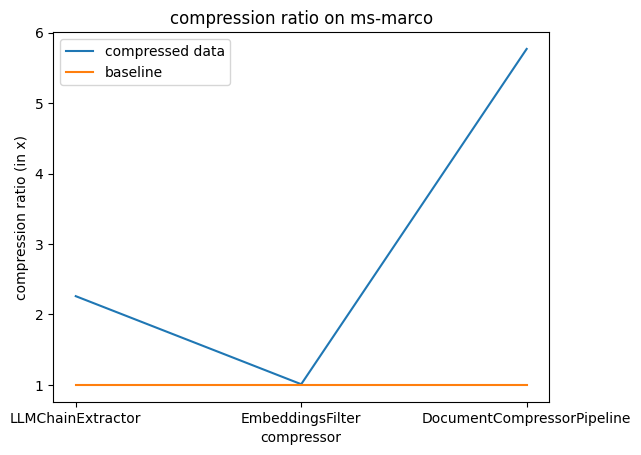

In [14]:

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(['LLMChainExtractor', 'EmbeddingsFilter', 'DocumentCompressorPipeline'], [2.26, 1.01, 5.77], label="compressed data")
ax.plot(['LLMChainExtractor', 'EmbeddingsFilter', 'DocumentCompressorPipeline'], [1.0, 1.0, 1.0], label="baseline")
ax.legend(loc="upper left")
ax.set_xlabel('compressor')
ax.set_ylabel('compression ratio (in x)')
ax.set_title('compression ratio on ms-marco')

plt.show()


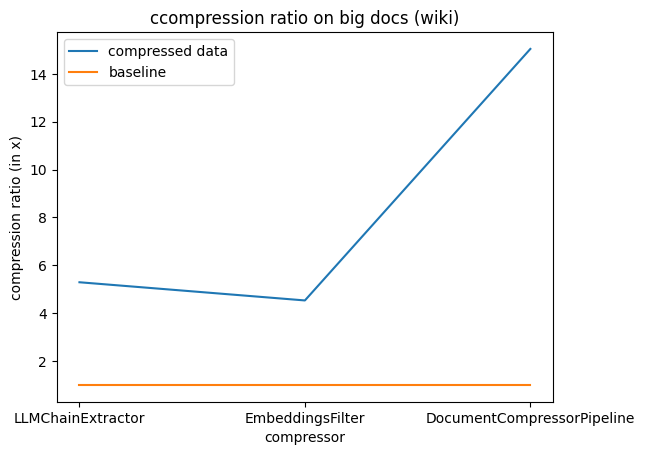

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(['LLMChainExtractor', 'EmbeddingsFilter', 'DocumentCompressorPipeline'], [5.29, 4.53, 15.04], label="compressed data")
ax.plot(['LLMChainExtractor', 'EmbeddingsFilter', 'DocumentCompressorPipeline'], [1.0, 1.0, 1.0], label="baseline")
ax.legend(loc="upper left")
ax.set_xlabel('compressor')
ax.set_ylabel('compression ratio (in x)')
ax.set_title('ccompression ratio on big docs (wiki)')

plt.show()

In [17]:
import pandas as pd
results_dff = pd.read_excel('data/comparision_results_df.xlsx')
results_dff

,Retriever,Reranker,recall,precision,f1
0,baseline_FAISS,without_reranker,45.472579,54.085855,49.406629
1,baseline_FAISS,bge_reranker_base,44.633456,53.807125,48.792844
2,baseline_FAISS,colbert2.0,45.916832,58.463963,51.436281
3,cc_llmChainExtractor,without_reranker,47.070420,61.306926,53.253616
4,cc_llmChainExtractor,bge_reranker_base,43.665858,57.094742,49.485432
5,cc_llmChainExtractor,colbert2.0,45.205592,58.454291,50.983288
6,cc_embeddingsFilter,without_reranker,45.567472,56.506424,50.450801
7,cc_embeddingsFilter,bge_reranker_base,NaN,NaN,NaN
8,cc_embeddingsFilter,colbert2.0,45.927817,59.433381,51.815004
9,cc_docCompressorPipeline,without_reranker,43.942254,57.837087,49.941215


In [18]:
results_dff[results_dff['Reranker'] == 'without_reranker']

,Retriever,Reranker,recall,precision,f1
0,baseline_FAISS,without_reranker,45.472579,54.085855,49.406629
3,cc_llmChainExtractor,without_reranker,47.070420,61.306926,53.253616
6,cc_embeddingsFilter,without_reranker,45.567472,56.506424,50.450801
9,cc_docCompressorPipeline,without_reranker,43.942254,57.837087,49.941215


In [21]:
results_dff[results_dff['Reranker'] == 'bge_reranker_base']

,Retriever,Reranker,recall,precision,f1
1,baseline_FAISS,bge_reranker_base,44.633456,53.807125,48.792844
4,cc_llmChainExtractor,bge_reranker_base,43.665858,57.094742,49.485432
7,cc_embeddingsFilter,bge_reranker_base,NaN,NaN,NaN
10,cc_docCompressorPipeline,bge_reranker_base,NaN,NaN,NaN


In [22]:
results_dff[results_dff['Reranker'] == 'colbert2.0']

,Retriever,Reranker,recall,precision,f1
2,baseline_FAISS,colbert2.0,45.916832,58.463963,51.436281
5,cc_llmChainExtractor,colbert2.0,45.205592,58.454291,50.983288
8,cc_embeddingsFilter,colbert2.0,45.927817,59.433381,51.815004
11,cc_docCompressorPipeline,colbert2.0,45.279092,55.167481,49.736559


In [31]:
x = results_dff[results_dff['Reranker'] == 'without_reranker']['Retriever']
y = results_dff[results_dff['Reranker'] == 'without_reranker']['f1']
x, y

(0              baseline_FAISS
 3        cc_llmChainExtractor
 6         cc_embeddingsFilter
 9    cc_docCompressorPipeline
 Name: Retriever, dtype: object,
 0    49.406629
 3    53.253616
 6    50.450801
 9    49.941215
 Name: f1, dtype: float64)

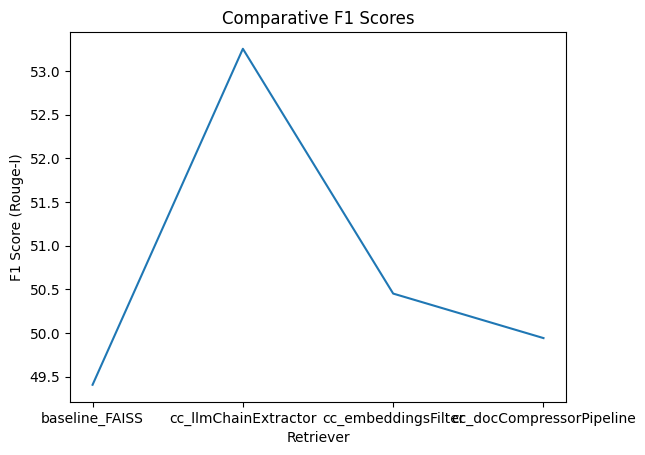

In [32]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.xlabel('Retriever')
plt.ylabel('F1 Score (Rouge-l)')
plt.title('Comparative F1 Scores')
# plt.xlim(-0.5, len(x) - 2.5)

# for i, x in enumerate(y):
#     j = y[i]
#     plt.text(x, j, j, verticleallignment="top")
# plt.show()
 
plt.show()

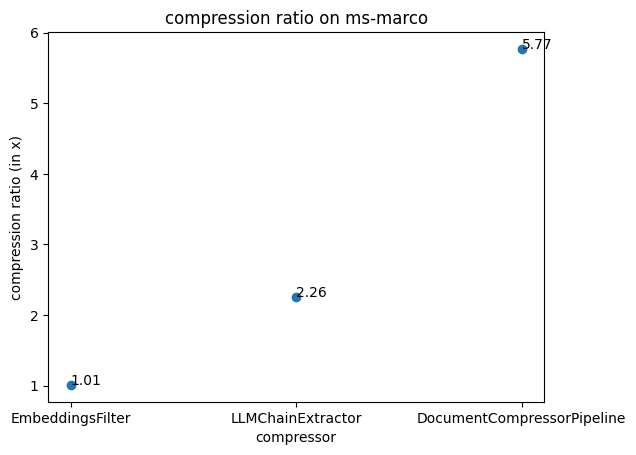

In [9]:
# 'compressor': ['LLMChainExtractor', 'EmbeddingsFilter', 'DocumentCompressorPipeline'],
#                              'compression ratio on ms-marco': ['2.26x', '1.01x', '5.77x'],
#                              'compression ratio on big docs (wiki)': ['5.29x', '4.53x', '15.04x'],

import matplotlib.pyplot as plt
 
x = ['EmbeddingsFilter', 'LLMChainExtractor', 'DocumentCompressorPipeline']
y = [1.01, 2.26, 5.77]
 
plt.scatter(x, y)
for i, txt in enumerate(y):
    plt.annotate(txt, (x[i], y[i]))

plt.xlabel('compressor')
plt.ylabel('compression ratio (in x)')
plt.title('compression ratio on ms-marco')
 
# To show the plot
plt.show()

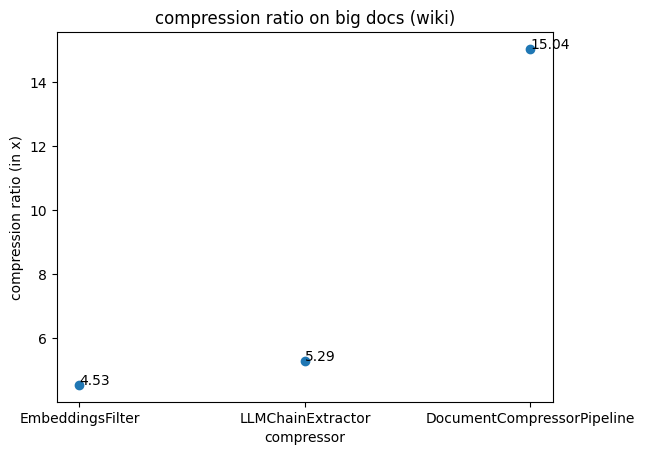

In [11]:
x = ['EmbeddingsFilter', 'LLMChainExtractor', 'DocumentCompressorPipeline']
y = [4.53, 5.29, 15.04]

plt.scatter(x, y)
for i, txt in enumerate(y):
    plt.annotate(txt, (x[i], y[i]))

plt.xlabel('compressor')
plt.ylabel('compression ratio (in x)')
plt.title('compression ratio on big docs (wiki)')
 
# To show the plot
plt.show()

In [13]:
import pandas as pd
results_dff = pd.read_excel('data/comparision_results_df.xlsx')
results_dff

,Retriever,Reranker,recall,precision,f1
0,baseline_FAISS,without_reranker,45.472579,54.085855,49.406629
1,baseline_FAISS,bge_reranker_base,44.633456,53.807125,48.792844
2,baseline_FAISS,colbert2.0,45.916832,58.463963,51.436281
3,cc_llmChainExtractor,without_reranker,47.070420,61.306926,53.253616
4,cc_llmChainExtractor,bge_reranker_base,43.665858,57.094742,49.485432
5,cc_llmChainExtractor,colbert2.0,45.205592,58.454291,50.983288
6,cc_embeddingsFilter,without_reranker,45.567472,56.506424,50.450801
7,cc_embeddingsFilter,bge_reranker_base,NaN,NaN,NaN
8,cc_embeddingsFilter,colbert2.0,45.927817,59.433381,51.815004
9,cc_docCompressorPipeline,without_reranker,43.942254,57.837087,49.941215


In [14]:
x = results_dff[results_dff['Reranker'] == 'without_reranker']['Retriever']
y = results_dff[results_dff['Reranker'] == 'without_reranker']['f1']
x, y

(0              baseline_FAISS
 3        cc_llmChainExtractor
 6         cc_embeddingsFilter
 9    cc_docCompressorPipeline
 Name: Retriever, dtype: object,
 0    49.406629
 3    53.253616
 6    50.450801
 9    49.941215
 Name: f1, dtype: float64)

In [16]:
y = y.apply(lambda x: round(x, 2))
y

0    49.41
3    53.25
6    50.45
9    49.94
Name: f1, dtype: float64

In [19]:
xl = x.tolist()
yl = y.tolist()

xl, yl

(['baseline_FAISS',
  'cc_llmChainExtractor',
  'cc_embeddingsFilter',
  'cc_docCompressorPipeline'],
 [49.41, 53.25, 50.45, 49.94])

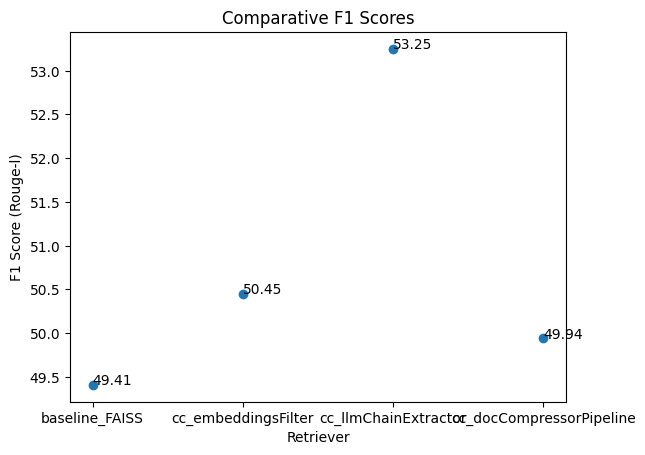

In [22]:
import matplotlib.pyplot as plt

xl = ['baseline_FAISS', 'cc_embeddingsFilter', 'cc_llmChainExtractor' , 'cc_docCompressorPipeline']
yl = [49.41, 50.45, 53.25, 49.94]
plt.scatter(xl, yl)
plt.xlabel('Retriever')
plt.ylabel('F1 Score (Rouge-l)')
plt.title('Comparative F1 Scores')

for i, txt in enumerate(yl):
    plt.annotate(txt, (xl[i], yl[i]))
 
plt.show()

In [42]:
def f1(r, p):
    return (2*r*p)/(r+p)

f11 = list()
for r, p in zip(results_df['recall'], results_df['precision']):
    f11.append(f1(r, p))
f11

[49.40662939925947,
 48.7928437369689,
 51.436281477595315,
 53.25361578260301,
 49.485431532035896,
 50.98328788760514,
 50.45080086174936,
 nan,
 51.81500419294327,
 49.941214888988796,
 nan,
 49.73655909568716]

In [28]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain


template="""Evaluation Task: You are presented with two responses to a specific question. \
The first response is the ground truth, considered the accurate answer. \
The second response has been generated by a language learning model (LLM). \
Your role is to evaluate the quality of the LLM-generated response in comparison to the ground truth.
For your evaluation, consider the following criteria:
- Relevance: Does the LLM response directly address the question posed?
- Accuracy: Is the information in the LLM response correct and factual?
- Completeness: Does the LLM response adequately cover the essential points mentioned in the ground truth?
- Clarity: Is the LLM response clearly written and easy to understand?
- Insightfulness: Does the LLM response provide meaningful and insightful information in response to the question?
Based on these criteria, strictly assign a score between 1 and 5, where:
- 1 indicates a poor response (the LLM response significantly lacks relevance, accuracy, completeness, clarity, or insight),
- 2 suggests a below-average response (the LLM response has notable deficiencies in one or more criteria),
- 3 denotes an average response (the LLM response adequately meets the criteria but may not excel),
- 4 represents a good response (the LLM response is strong in most criteria, perhaps lacking slightly in one),
- 5 signifies an excellent response (the LLM response excels across all criteria, offering a comprehensive, clear, and insightful answer).
Question: {question}
Ground Truth Response: {expected_answer}
LLM-Generated Response: {llm_answer}
Evaluation Score: """

eval_llm = bam_model(model_id="ibm/granite-13b-instruct-v2", decoding_method="sample")

prompt = PromptTemplate(template=template, input_variables=["question", "expected_answer", "llm_answer"])

In [29]:
llm_chain = LLMChain(prompt=prompt, llm=eval_llm)
eval=llm_chain.predict(question=df_dcp_colbert['question'][0], 
                       expected_answer=df_dcp_colbert['ground_truths'][0][0], 
                       llm_answer=df_dcp_colbert['answer'][0])

eval

'3'

In [31]:
df_dcp_colbert['question'][:30].tolist()

['walgreens store sales average',
 'how much do bartenders make',
 'what is a furuncle boil',
 'what can urinalysis detect',
 'what is vitamin a used for',
 'what causes genetic alterations in normal cells',
 'cost to frame basement',
 'erudite divergent definition',
 'why is albumin normally absent in urine',
 'where was movie the birds filmed',
 'cost to file bankruptcy in virginia',
 'what is a hummingbird moth',
 'what does a western blot detect',
 'what is vegetable bouillon',
 'want is tom cruise doing now',
 'what means irie',
 'what is baseball twine made of',
 'What Does Lop means',
 'how much do tuna fishers first mates make',
 'how to start gypsophila elegans seeds',
 'how long to get masters degree',
 'what is treatment for jaundice',
 'replacing permanent resident card canada',
 'what is a purified phytochemical',
 'definition of IBR disease',
 'what landform makes a u shaped valley',
 "ovulation usually occurs on day _____ of a woman's cycle",
 'what kind of tick has rock

In [ ]:
from llama_index import ServiceContext
from llama_index.evaluation import FaithfulnessEvaluator
from llama_index.evaluation import RelevancyEvaluator
from llama_index.evaluation import BatchEvalRunner
from llama_index import set_global_service_context

langchain_model = bam_model(model_id='mistralai/mistral-7b-instruct-v0-2', decoding_method='sample')
service_context_mistral = ServiceContext.from_defaults( llm=langchain_model,
                                                       embed_model=embeddings_model)
set_global_service_context(service_context_mistral)

faithfulness_mistral = FaithfulnessEvaluator(service_context=service_context_mistral)
relevancy_mistral = RelevancyEvaluator(service_context=service_context_mistral)

batch_eval_queries = df_dcp_colbert['question'][:30].tolist()

runner = BatchEvalRunner({
    "faithfulness": faithfulness_mistral, "relevancy": relevancy_mistral},
    workers=8,)

In [ ]:
from llama_index.retrievers import (
    BaseRetriever,
    VectorIndexRetriever,
)
from llama_index import ServiceContext, VectorStoreIndex

service_context = ServiceContext.from_defaults(llm=llm, embed_model=embeddings_model)
set_global_service_context(service_context)
vector_index = VectorStoreIndex(nodes, service_context=service_context)
vector_retriever = VectorIndexRetriever(index=vector_index, similarity_top_k=3, service_context=service_context)